<a href="https://colab.research.google.com/github/biku1998/NLP-Notebooks/blob/master/NLP_04_Topic_Modeling_LDA_Gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Topic Modeling using LDA with Gensim

In [1]:
from IPython.display import YouTubeVideo

####  To understand LDA better i would highly recommend watching these 2 videos. 

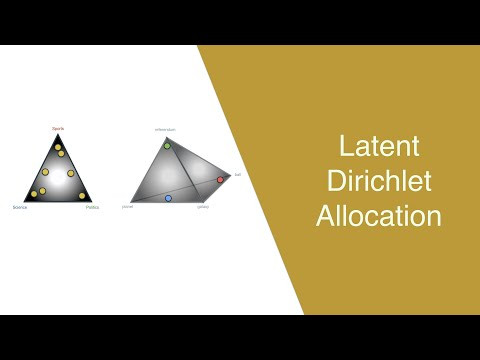

In [2]:
YouTubeVideo("T05t-SqKArY",width=700,height = 500)

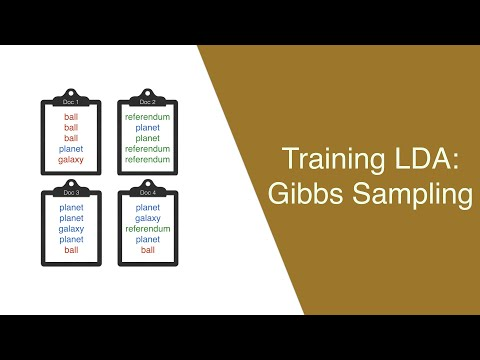

In [3]:
YouTubeVideo("BaM1uiCpj_E",width=700,height = 500)

**Let's Start Implementing LDA**

We will use fake news dataset from kaggle <a href = "https://www.kaggle.com/mrisdal/fake-news">Here</a>

In [4]:
import pandas as pd

In [5]:
df_fake_news = pd.read_csv("./Data/fake.csv")

In [6]:
df_fake_news = df_fake_news[['title','text','language']]

df_fake_news = df_fake_news.loc[(pd.notnull(df_fake_news.title)) & \
                                (pd.notnull(df_fake_news.text)) & (df_fake_news.language == 'english')]

df_fake_news = df_fake_news.reset_index(drop = True)

df_fake_news.head()

title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   

                                                text language  
0  Print They should pay all the back all the mon...  english  
1  Why Did Attorney General Loretta Lynch Plead T...  english  
2  Red State : \nFox News Sunday reported this mo...  english  
3  Email Kayla Mueller was a prisoner and torture...  english  
4  Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...  english

In [31]:
# no of articles
df_fake_news.shape

(11677, 3)

In [7]:
# pre-process imports

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os,re
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation
import nltk
nltk.download("wordnet")

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sourabh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def pre_process_news(texts):
    
    # tokenization
    print("Tokenization ...")
    texts = [re.findall(r'\w+', line.lower()) for line in tqdm(texts,total = texts.shape[0])]
    
    # remove stopwords
    print("Stop Word removal ...")
    texts = [remove_stopwords(' '.join(line)).split() for line in tqdm(texts)]
    
    # remove punctuation
    print("Punctuation removal...")
    texts = [strip_punctuation(' '.join(line)).split() for line in tqdm(texts)]
    
    # remove words that are only 1-2 character
    texts = [[token for token in line if len(token) > 2] for line in texts]
    
    # remove numbers
    texts = [[token for token in line if not token.isnumeric()] for line in texts]
    
    # lemmatization 
    print("Lemmatization ...")
    lemmatizer = WordNetLemmatizer()
    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in tqdm(texts)]
    
    return texts

In [9]:
news_cleaned = pre_process_news(df_fake_news.text)

Tokenization ...



Stop Word removal ...



Punctuation removal...



Lemmatization ...


In [10]:
# look at a random index
idx = np.random.choice(len(news_cleaned))
news_cleaned[idx]

['usa',
 'today',
 'lying',
 'anti',
 'trump',
 'protests',
 'spontaneous',
 'http',
 'www',
 'zerohedge',
 'com',
 'news',
 'anti',
 'trump',
 'protests',
 'proof',
 'professional',
 'activist',
 'involvement',
 'post',
 'usa',
 'today',
 'lying',
 'anti',
 'trump',
 'protests',
 'spontaneou',
 'appeared',
 'paulcraigroberts',
 'org']

In [11]:
# bi gram collection detection

from gensim.models.phrases import Phraser,Phrases

# train the bigram det

phrases = Phrases(news_cleaned,min_count = 1,threshold = 0.8,scoring = 'npmi')

In [12]:
Phrases??

In [13]:
# now we create a transformer that will use the above trained model to transform new words

bi_gram = Phraser(phrases)

In [14]:
# let's try out some examples

print(bi_gram[['white', 'house', 'million', 'money']])

['white_house', 'million', 'money']


In [15]:
# merging detected collocations with data

news_cleaned = list(bi_gram[news_cleaned])

In [16]:
# creating a numerical mapping for each word

from gensim.corpora import Dictionary

In [17]:
dictionary = Dictionary(news_cleaned)

In [18]:
# remove rare words and most common words to improve our topic modeling

# Filter out words that occur less than 10 documents, or more than 60% of the documents.

dictionary.filter_extremes(no_below=10, no_above=0.6)

In [19]:
#  transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams.

corpus = [dictionary.doc2bow(text) for text in news_cleaned]

In [20]:
doc_number = 0
corpus[doc_number] # A document is represented as a list of tuples of (vocab ID, frequency) for each word.

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1)]

In [21]:
# train the lda model

from gensim.models import LdaModel

# LdaModel?? # to know about the class parameters

In [0]:
lda_models = LdaModel(corpus = corpus, id2word = dictionary, num_topics = 35, \
                      passes = 50, chunksize = 1500,iterations = 200,alpha = "auto")

In [0]:
# once the model is trained we save the model

if os.path.isdir("./topic_models") == False:
    os.mkdir("./topic_models")
    
lda_models.save("./topic_models/lda_model")

In [22]:
# let's how the topics

# load the modal 

lda_model  = LdaModel.load("./topic_models/lda_model")

In [23]:
lda_model.show_topics(num_topics = 5)

[(30,
  '0.022*"native" + 0.019*"indian" + 0.017*"world" + 0.015*"people" + 0.011*"american" + 0.010*"indians" + 0.010*"indigenous" + 0.010*"google" + 0.010*"peoples" + 0.009*"new"'),
 (31,
  '0.044*"court" + 0.029*"case" + 0.024*"judge" + 0.023*"federal" + 0.018*"said" + 0.017*"attorney" + 0.015*"trial" + 0.015*"jury" + 0.014*"ryan" + 0.012*"district"'),
 (9,
  '0.012*"podesta" + 0.012*"wikileaks" + 0.010*"campaign" + 0.009*"email" + 0.008*"john" + 0.006*"information" + 0.005*"documents" + 0.005*"public" + 0.005*"story" + 0.005*"secret"'),
 (29,
  '0.010*"people" + 0.006*"right" + 0.005*"public" + 0.005*"american" + 0.005*"fact" + 0.004*"times" + 0.004*"america" + 0.004*"gun" + 0.003*"truth" + 0.003*"real"'),
 (5,
  '0.021*"like" + 0.018*"people" + 0.014*"going" + 0.014*"know" + 0.013*"time" + 0.011*"think" + 0.009*"good" + 0.009*"want" + 0.008*"way" + 0.007*"right"')]

reading the output : each element in the list consist of tuples
we have

`(30,
  '0.022*"native" + 0.019*"indian" + 0.017*"world" + 0.015*"people" + 0.011*"american" + 0.010*"indians" + 0.010*"indigenous" + 0.010*"google" + 0.010*"peoples" + 0.009*"new"')`

* The first part of the tuple is i.e `30` here is topic number
* Sequence of words that mainly describes these topics
    * The sequence also has 2 parts e.g `'0.022*"native"` the numerical part is the probability of that word being present in this particular topic.

**we also have a function , that given a word it returns the `probability` of that word `expressed` in that topic**

In [24]:
lda_model.get_term_topics("money")

[(4, 0.014090805), (21, 0.016289188)]

We can also get **topic distribution** from a given corpus.For this we can use the `get_document_topics` method.
This method also return `word distribution` inside that document which are `sorted` in `topic wise probability`

In [25]:
doc_number = 12

doc_topic, word_topic, phi_value = lda_model.get_document_topics(corpus[doc_number],per_word_topics = True)

In [26]:
doc_topic

[(0, 0.0235466),
 (3, 0.10136958),
 (5, 0.023071038),
 (8, 0.13451295),
 (9, 0.05665098),
 (11, 0.01566418),
 (14, 0.044509493),
 (16, 0.061121624),
 (17, 0.2256717),
 (23, 0.020911587),
 (26, 0.063347675),
 (27, 0.011009264),
 (28, 0.013566244),
 (29, 0.030368263),
 (33, 0.16944148)]

In this document i.e `12` here. We have `0.0235466` percent of **topic 0**, `0.10136958` of **topic 3** and so on.
It's called `topic distribution of document`

In [27]:
word_topic

[(20, [17, 9, 26, 23, 3, 16, 27, 29, 28]),
 (32, [17, 33, 14, 5, 3, 29, 26, 9, 23, 8]),
 (55, [11, 16, 9, 3, 29]),
 (63, [17, 3, 5, 29, 8, 26]),
 (98, [33, 26, 14, 9, 16, 0, 3, 28, 8, 11]),
 (105, [14, 3, 9, 26, 28, 0, 5]),
 (143, [17, 8, 23, 14]),
 (164, [17, 26, 23, 11, 28]),
 (199, [3, 9, 26, 16, 0, 28, 27]),
 (203, [9, 28, 3, 16, 29]),
 (223, [9, 11, 28, 14, 8, 3]),
 (227, [17, 8, 16, 5, 23, 29]),
 (233, [14, 16, 3, 9, 26, 0, 28]),
 (240, [16, 3, 14]),
 (241, [8, 17, 5, 3, 14, 11, 29, 27, 16]),
 (261, [17, 5, 23, 8, 11, 9, 3, 29, 27, 14]),
 (265, [9, 27, 16, 3]),
 (276, [17, 26, 3, 29, 27, 11, 9, 5]),
 (286, [17, 33, 3, 29, 23, 14, 9, 16]),
 (298, [17, 33, 8, 5, 14, 26, 9, 23, 28, 0]),
 (307, [8, 17, 29]),
 (312, [17, 8, 5, 29, 3, 14, 16]),
 (318, [17, 26, 9, 23, 27, 14, 28]),
 (344, [5, 14, 11, 3, 9, 28, 27]),
 (346, [17, 5, 8, 29, 14]),
 (352, [16, 8, 5, 29, 14, 9]),
 (355, [8, 17, 9, 26, 16, 5]),
 (378, [9, 14, 29]),
 (384, [16, 3, 5, 9, 28]),
 (386, [3, 16, 11, 26, 0, 9, 5, 28]

In word_topic we get the `probability distribution` of each word in that document.

For example take the first tuple in the list
    `(20, [17, 9, 26, 23, 3, 16, 27, 29, 28])` here `20` is word index in our dictionary. and `[17, 9, 26, 23, 3, 16, 27, 29, 28]` is the list of topic numbers which are `ranked` according to the `probability`. Like word at index 20 in the dictionary has the `highest` probability to show in topic `17` then `9` and so on.
    
But can we see those probabilities ?

    Yes in phi_value

In [28]:
phi_value

[(20,
  [(3, 0.096538976),
   (9, 0.13362174),
   (16, 0.07135544),
   (17, 0.40303573),
   (23, 0.10794815),
   (26, 0.13038811),
   (27, 0.02342666),
   (28, 0.013949293),
   (29, 0.019049268)]),
 (32,
  [(3, 0.055850726),
   (5, 0.06948748),
   (8, 0.028622974),
   (9, 0.036000185),
   (14, 0.08722398),
   (17, 0.44663528),
   (23, 0.03320671),
   (26, 0.03850583),
   (29, 0.042245675),
   (33, 0.15638104)]),
 (55,
  [(3, 0.054890368),
   (9, 0.091821246),
   (11, 0.6244289),
   (16, 0.19584161),
   (29, 0.023688544)]),
 (63,
  [(3, 0.105092615),
   (5, 0.07132318),
   (8, 0.041928567),
   (17, 0.6947648),
   (26, 0.027470596),
   (29, 0.049154628)]),
 (98,
  [(0, 0.116484046),
   (3, 0.077749215),
   (8, 0.06625596),
   (9, 0.17417099),
   (11, 0.04776352),
   (14, 0.2379941),
   (16, 0.124634035),
   (26, 1.1446742),
   (28, 0.07540236),
   (33, 2.9341776)]),
 (105,
  [(0, 0.1618558),
   (3, 1.1020248),
   (5, 0.10481829),
   (9, 0.73486537),
   (14, 1.1882823),
   (26, 0.41527992

### Evaluation of topic models
> Manual : using a tool called `pyLDAvis`

In [37]:
import pyLDAvis.gensim

# set the notebook model
pyLDAvis.enable_notebook()

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
pyLDAvis.gensim.prepare(lda_model,corpus,dictionary,sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.041574 -0.009631       1        1   0.764003
1     -0.199806 -0.127247       2        1   0.914439
2     -0.168973 -0.006144       3        1   2.474656
3      0.131348  0.107234       4        1   3.488333
4      0.095749  0.128162       5        1   2.945904
5     -0.089565  0.075399       6        1  10.052957
6     -0.068647 -0.092564       7        1   0.613760
7      0.080146  0.136640       8        1   5.100129
8     -0.182576  0.106799       9        1   3.888457
9      0.073221  0.018009      10        1   4.254042
10     0.134758 -0.121239      11        1   1.878036
11    -0.067935 -0.148384      12        1   1.414872
12     0.122308 -0.141972      13        1   2.313590
13    -0.107076 -0.030774      14        1   1.694812
14     0.091144  0.187319      15        1   5.836486
15    -0.081556 -0.094734      16        1   1.805357
16     0.183705  0.060853      17        1   4.226486
17    -0.143634  0.194151      18        1   5.370930
18    -0.034034 -0.187001      19        1   0.522906
19     0.050747 -0.042416      20        1   0.855433
20     0.037509 -0.095251      21        1   1.287952
21    -0.031270  0.049306      22        1   2.207777
22    -0.020445 -0.111381      23        1   2.475853
23    -0.195378  0.047379      24        1   2.331316
24    -0.063494  0.083297      25        1   3.987269
25     0.122587 -0.118087      26        1   1.664422
26     0.064369 -0.006235      27        1   3.746977
27    -0.080849  0.030135      28        1   2.370435
28     0.154416  0.090342      29        1   4.820700
29    -0.020774  0.143442      30        1   7.170832
30    -0.086672  0.058839      31        1   0.637440
31     0.145512 -0.111765      32        1   0.738874
32     0.105227 -0.011849      33        1   2.203379
33    -0.061018 -0.105637      34        1   1.163731
34     0.069382  0.045004      35        1   2.777459, topic_info=     Category          Freq           Term         Total  loglift  logprob
240   Default  25318.000000          trump  25318.000000  30.0000  30.0000
156   Default  23725.000000        clinton  23725.000000  29.0000  29.0000
177   Default  15722.000000        hillary  15722.000000  28.0000  28.0000
2223  Default   8441.000000         russia   8441.000000  27.0000  27.0000
668   Default  10784.000000       election  10784.000000  26.0000  26.0000
101   Default   9692.000000          obama   9692.000000  25.0000  25.0000
55    Default   5288.000000            com   5288.000000  24.0000  24.0000
170   Default   6245.000000            fbi   6245.000000  23.0000  23.0000
221   Default   6630.000000         donald   6630.000000  22.0000  22.0000
2876  Default   9375.000000            war   9375.000000  21.0000  21.0000
143   Default  11646.000000          world  11646.000000  20.0000  20.0000
312   Default  20393.000000         people  20393.000000  19.0000  19.0000
11    Default  10311.000000     government  10311.000000  18.0000  18.0000
200   Default  14797.000000           said  14797.000000  17.0000  17.0000
1118  Default   8394.000000          media   8394.000000  16.0000  16.0000
2816  Default   4712.000000          syria   4712.000000  15.0000  15.0000
809   Default   3663.000000          black   3663.000000  14.0000  14.0000
233   Default  10679.000000      president  10679.000000  13.0000  13.0000
2224  Default   5264.000000        russian   5264.000000  12.0000  12.0000
360   Default   7597.000000       campaign   7597.000000  11.0000  11.0000
558   Default   4061.000000         police   4061.000000  10.0000  10.0000
995   Default   4943.000000           life   4943.000000   9.0000   9.0000
137   Default  10983.000000          state  10983.000000   8.0000   8.0000
795   Default   3057.000000          white   3057.000000   7.0000   7.0000
14    Default  12974.000000           like  12974.000000   6.0000   6.0000
39    Def

**Reading the Above plot**

---

`Left Panel`
   
   * The circles represents the topics
   * The size of the circle represents the prevalence of that topic in our corpus
       * So $ \uparrow$ **radius** of circle $ \uparrow$ **importance** of that topic in our corpus
   * The plot is designed according to the inter-topic distances i.e topics that are closer to each other are actually `semantically` related
   * Using the the plot we can also see the cluster of similar topics
   * We will see another visualization in which we can actually see the distance between these topics
   
---

`Right Panel`

   * If we don't select any topic, we will get a list of top 30 salient terms i.e `most important` words in our corpus.
   * If we see closely these salient terms, we can actually `infer` the our corpus has mostly around politics
   * If we select a topic on left panel i.e `click on any topic` circle. We will get top 30 relevant terms for this particular topic.
   
   <img src = "./assets/get_relevent_words_for_topic_click.gif">
   
   * So the most important words for topic 15 and in the dataset is `obama,president,american` [the topics are normalized]
   * What does these blue and red bar represent ?
       * The `blue bar` is the total frequency of that word in our corpus.
       * The `red bar` represents the frequency of this word in the selected topics
   * What is the use of that slider on the top ?
       * As we decrease the value if $\lambda$ only those words will appear that are present in that topic in order  of frequency.
       
    <img src = "./assets/get_targeted_words.gif">
    
   
   * **Note** if set our $\lambda$ to high we will get more general terms which will make topic differentiation hard. On the other hand if we make $\lambda$ too small we will get very rare words which can be harder to interpret. So the optimum value is somewhere close to `0.6`
       
   ---
   






### Document Clustering using LDA on Tensorboard

- This is one of the application of lda topic models. We can cluster large no of similar documents using the `get_document_topics`
- we can visualize the documents based on their topic distribution. That topic distribution representation of each document can be used for clustering the semantically similar documents together.

In [29]:
# Get document topics
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0)
all_topics[0]

[(0, 0.0015526713),
 (1, 0.0013866648),
 (2, 0.0018191207),
 (3, 0.057284687),
 (4, 0.0028765094),
 (5, 0.16628158),
 (6, 0.001687968),
 (7, 0.00277773),
 (8, 0.004809394),
 (9, 0.0060088495),
 (10, 0.0013930599),
 (11, 0.003807185),
 (12, 0.0036468774),
 (13, 0.0025833072),
 (14, 0.0044071167),
 (15, 0.0029291445),
 (16, 0.0052217017),
 (17, 0.0049344106),
 (18, 0.0012342652),
 (19, 0.19706385),
 (20, 0.0024056437),
 (21, 0.16254078),
 (22, 0.0034481853),
 (23, 0.0029712096),
 (24, 0.003913141),
 (25, 0.0013921055),
 (26, 0.0042417264),
 (27, 0.10845948),
 (28, 0.0027476838),
 (29, 0.013032304),
 (30, 0.0012213063),
 (31, 0.0012237823),
 (32, 0.0025819174),
 (33, 0.0025109255),
 (34, 0.21360378)]

In [30]:
# len of all topics
len(all_topics) # we have topic distribution of all the articles.

11677

Now, using the topic distribution of a document as it's `vector representation`, we will plot all the documents in our corpus using `Tensorboard`

<u>Tensorboard req:</u>

- Tensorboard takes two input files, one containing the embedding vectors and the other containing relevant metadata.         As described above, we will use the topic distribution of documents as their representative vector and the metadata        file will consist of Document titles. And the format of files normally is ".tsv"
- For meta-data we can just use the titles of articles.

In [32]:
# create file for tensors(vectors)
with open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t") # store the probablity value
        w.write("\n")

In [36]:
# create file for metadata(documet titles)
with open('doc_lda_metadata.tsv','w',encoding="utf-8") as w:
    for doc_id in range(len(all_topics)):
        w.write(df_fake_news.title[doc_id] + "\n")

* Now open - http://projector.tensorflow.org/
* upload both the files
* Upload both the files using the `load` button on the left

<img src = "./assets/topic_tensorboard.gif">